In [170]:
!wget https://raw.githubusercontent.com/aydink/pymgrs/master/mgrs.py

--2020-08-24 14:59:30--  https://raw.githubusercontent.com/aydink/pymgrs/master/mgrs.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.52.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21186 (21K) [text/plain]
Saving to: ‘mgrs.py’

mgrs.py             100%[===================>]  20.69K  --.-KB/s    in 0.02s   

2020-08-24 14:59:31 (969 KB/s) - ‘mgrs.py’ saved [21186/21186]



In [171]:
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches, colors
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import numpy.ma as ma
import pandas as pd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.mask as em
from scripts import mgrs

In [3]:
# Prettier plotting with seaborn
sns.set_style('white')
sns.set(font_scale=1.5)

In [4]:
os.chdir("/Users/user/Documents/GitHub/canopy-gis/data_collection/data/sample_data")

In [5]:
!pwd

/Users/user/Documents/GitHub/canopy-gis/data_collection/data/sample_data


# Earth-DS Tutorial

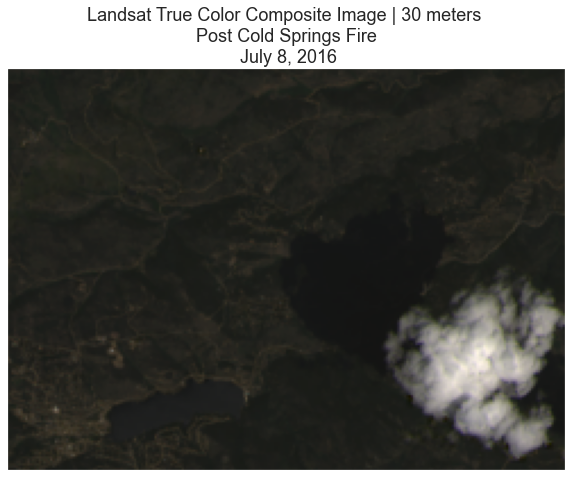

In [6]:
landsat_paths_pre_path = os.path.join("coldspringsfire", "landsat_collect", 
                                      "LC080340322016070701T1-SC20180214145604", "crop", 
                                      "*band*.tif")

landsat_paths_pre = glob(landsat_paths_pre_path)
landsat_paths_pre.sort()

# Stack the Landsat pre fire data
landsat_pre_st_path = os.path.join("coldspringsfire", 
                                   "outputs", "landsat_pre_st.tif")

es.stack(landsat_paths_pre, landsat_pre_st_path)

# Read landsat pre fire data
with rio.open(landsat_pre_st_path) as landsat_pre_src:
    landsat_pre = landsat_pre_src.read(masked=True)
    landsat_extent = plotting_extent(landsat_pre_src)
    
ep.plot_rgb(landsat_pre,
            rgb=[3, 2, 1],
            extent=landsat_extent,
            title="Landsat True Color Composite Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")

plt.show()

In [7]:
landsat_pre_cl_path = os.path.join("coldspringsfire", "landsat_collect", 
                                   "LC080340322016070701T1-SC20180214145604", "crop", 
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

# Open the pixel_qa layer for your landsat scene
with rio.open(landsat_pre_cl_path) as landsat_pre_cl:
    landsat_qa = landsat_pre_cl.read(1)
    landsat_ext = plotting_extent(landsat_pre_cl)

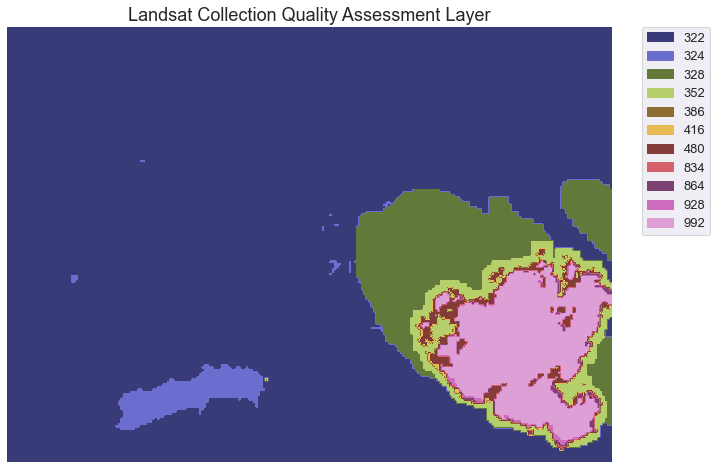

In [8]:
# This is optional code to plot the qa layer - don't worry too much about the details.
# Create a colormap with 11 colors
cmap = plt.cm.get_cmap('tab20b', 11)
# Get a list of unique values in the qa layer
vals = np.unique(landsat_qa).tolist()
bins = [0] + vals
# Normalize the colormap 
bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
    [(bins[-1] - bins[-2]) + bins[-1]]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(landsat_qa,
               cmap=cmap,
               norm=norm)

ep.draw_legend(im,
               classes=vals,
               cmap=cmap, titles=vals)

ax.set_title("Landsat Collection Quality Assessment Layer")
ax.set_axis_off()
plt.show()

# Senintel 2 L2A Cloud Mask Loading

In [323]:
sen_raster = '/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v1_Misha/Raw/L2A_T33NWA_A024214_20200210T092430/IMG_DATA/R10m/T33NWA_20200210T091121_TCI_10m.jp2'
sen_mask = '/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Tiles_v1_Misha/Raw/L2A_T33NWA_A024214_20200210T092430/QI_DATA/MSK_CLDPRB_20m.jp2'

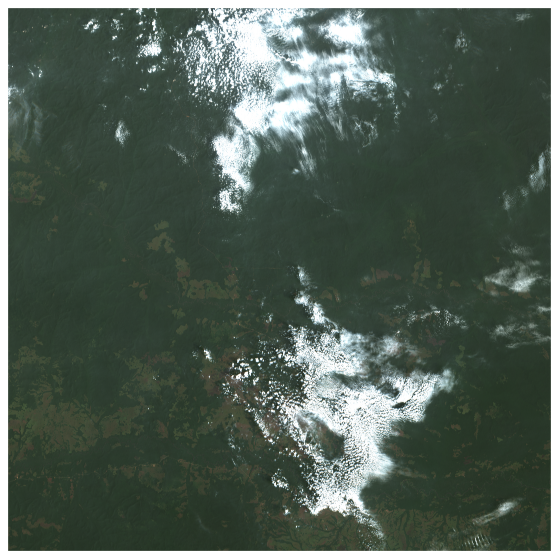

In [324]:
# Read landsat pre fire data
with rio.open(sen_raster) as landsat_pre_src:
    landsat_pre = landsat_pre_src.read(masked=True)
    
ep.plot_rgb(landsat_pre)

plt.show()

In [329]:
landsat_pre_src.meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(10.0, 0.0, 499980.0,
        0.0, -10.0, 100020.0)}

In [330]:
# Open the pixel_qa layer for your landsat scene
with rio.open(sen_mask) as landsat_pre_cl:
    landsat_qa = landsat_pre_cl.read(1)
    landsat_qa = np.repeat(np.repeat(landsat_qa,2,axis=0),2,axis=1)
    landsat_ext = plotting_extent(landsat_pre_cl)

In [331]:
landsat_qa.shape

(10980, 10980)

In [332]:
landsat_qa

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [333]:
landsat_qa_filtered = landsat_qa > 0

# masks_dict = {}
# for prob in range(1,102,10):
#     if prob == 101:
#         prob = 100
#     masks_dict[prob] = landsat_qa_filtered <= prob

In [334]:
landsat_qa_filtered

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [335]:
np.count_nonzero(landsat_qa_filtered == 0) / len(landsat_qa_filtered)**2

0.743916410363602

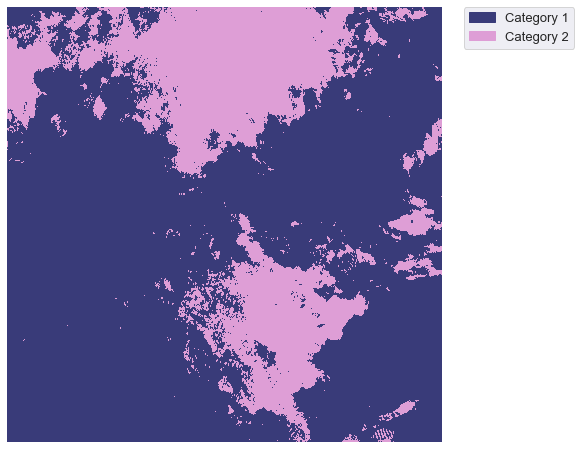

In [297]:
# This is optional code to plot the qa layer - don't worry too much about the details.
# Create a colormap with 101 colors
cmap = plt.cm.get_cmap('tab20b', 2)
# Get a list of unique values in the qa layer
vals = np.unique(landsat_qa_filtered).tolist()
bins = [0] + vals
# Normalize the colormap 
bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
    [(bins[-1] - bins[-2]) + bins[-1]]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(landsat_qa,
               cmap=cmap,
               norm=norm)

ep.draw_legend(im,
               classes=vals,
               cmap=cmap)

ax.set_axis_off()
plt.show()

In [152]:
# for mask in masks_dict.items():
#     # This is optional code to plot the qa layer - don't worry too much about the details.
#     # Create a colormap with 101 colors
#     cmap = plt.cm.get_cmap('tab20b', 2)
#     # Get a list of unique values in the qa layer
#     vals = np.unique(mask[1]).tolist()
#     bins = [0] + vals
#     # Normalize the colormap 
#     bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
#         [(bins[-1] - bins[-2]) + bins[-1]]
#     norm = colors.BoundaryNorm(bounds, cmap.N)

#     # Plot the data
#     fig, ax = plt.subplots(figsize=(12, 8))

#     im = ax.imshow(landsat_qa,
#                    cmap=cmap,
#                    norm=norm)

#     ep.draw_legend(im,
#                    classes=vals,
#                    cmap=cmap)

#     ax.set_title(f"{mask[0]}")
#     ax.set_axis_off()
#     plt.show()

In [336]:
landsat_qa_filtered.shape

(10980, 10980)

In [337]:
# landsat_pre_cl_free = em.mask_pixels(landsat_pre, masks_dict[1])

# Call the earthpy mask function using pixel QA layer
landsat_pre_cl_free = em.mask_pixels(
    landsat_pre, landsat_qa_filtered)


In [338]:
landsat_pre_cl_free

masked_array(
  data=[[[51, 52, 49, ..., 48, 50, 55],
         [49, 49, 49, ..., 51, 51, 55],
         [49, 51, 49, ..., 53, 51, 52],
         ...,
         [66, 64, 61, ..., 49, 48, 48],
         [71, 73, 65, ..., 48, 48, 48],
         [73, 72, 68, ..., 49, 48, 48]],

        [[65, 63, 63, ..., 63, 62, 66],
         [61, 63, 63, ..., 65, 63, 66],
         [62, 65, 63, ..., 68, 66, 67],
         ...,
         [69, 67, 62, ..., 61, 63, 62],
         [67, 66, 63, ..., 63, 64, 64],
         [68, 65, 65, ..., 62, 63, 63]],

        [[54, 54, 55, ..., 53, 56, 59],
         [56, 57, 56, ..., 55, 53, 56],
         [57, 58, 56, ..., 54, 53, 54],
         ...,
         [48, 51, 48, ..., 46, 45, 45],
         [48, 49, 48, ..., 45, 42, 45],
         [51, 48, 49, ..., 44, 43, 46]]],
  mask=[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False,

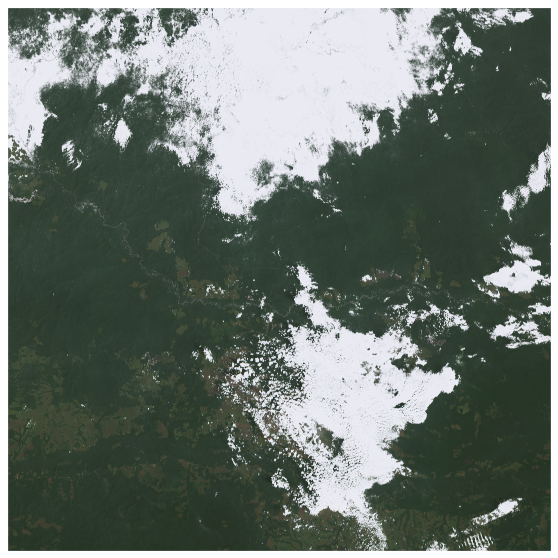

In [346]:
ep.plot_rgb(landsat_pre_cl_free,extent=landsat_ext)

plt.show()

In [347]:
landsat_pre_cl_free

masked_array(
  data=[[[51, 52, 49, ..., 48, 50, 55],
         [49, 49, 49, ..., 51, 51, 55],
         [49, 51, 49, ..., 53, 51, 52],
         ...,
         [66, 64, 61, ..., 49, 48, 48],
         [71, 73, 65, ..., 48, 48, 48],
         [73, 72, 68, ..., 49, 48, 48]],

        [[65, 63, 63, ..., 63, 62, 66],
         [61, 63, 63, ..., 65, 63, 66],
         [62, 65, 63, ..., 68, 66, 67],
         ...,
         [69, 67, 62, ..., 61, 63, 62],
         [67, 66, 63, ..., 63, 64, 64],
         [68, 65, 65, ..., 62, 63, 63]],

        [[54, 54, 55, ..., 53, 56, 59],
         [56, 57, 56, ..., 55, 53, 56],
         [57, 58, 56, ..., 54, 53, 54],
         ...,
         [48, 51, 48, ..., 46, 45, 45],
         [48, 49, 48, ..., 45, 42, 45],
         [51, 48, 49, ..., 44, 43, 46]]],
  mask=[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False,

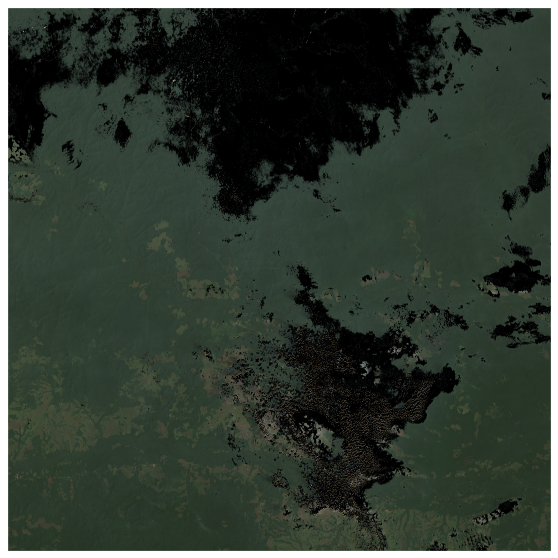

In [348]:
nodatavalue = 0 

ep.plot_rgb(np.ma.filled(landsat_pre_cl_free, fill_value=nodatavalue),extent=landsat_ext)

plt.show()

In [355]:
landsat_TCI_meta = landsat_pre_src.meta
# landsat_TCI_meta["nodata"] = nodatavalue

In [356]:
landsat_TCI_meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(10.0, 0.0, 499980.0,
        0.0, -10.0, 100020.0)}

In [357]:
sen_TCI_cl_nan_free = np.ma.filled(landsat_pre_cl_free, fill_value=int(0))
output_dir = '/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Test/CL_free/'

with rio.open(output_dir + "Test.jp2", 'w', **landsat_TCI_meta) as outf:
    outf.write(sen_TCI_cl_nan_free)

# Attempt at utilizing SCL file for classification

In [235]:
sen_raster = '/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Test/34MDA,2020-08-24,0/R10m/TCI.jp2'
sen_mask = '/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Test/34MDA,2020-08-24,0/R20m/SCL.jp2'

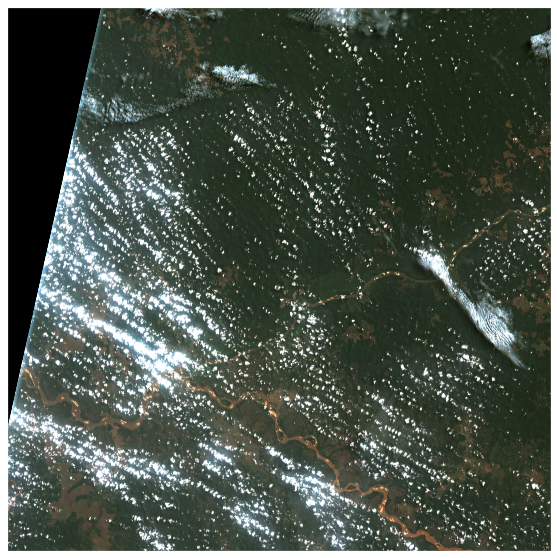

In [236]:
# Read landsat pre fire data
with rio.open(sen_raster) as landsat_pre_src:
    landsat_pre = landsat_pre_src.read(masked=True)
    
ep.plot_rgb(landsat_pre)

plt.show()

In [237]:
landsat_pre_src.meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32734),
 'transform': Affine(10.0, 0.0, 399960.0,
        0.0, -10.0, 9600040.0)}

In [238]:
# Open the pixel_qa layer for your landsat scene
with rio.open(sen_mask) as landsat_pre_cl:
    landsat_qa = landsat_pre_cl.read(1)
    landsat_qa = np.repeat(np.repeat(landsat_qa,2,axis=0),2,axis=1)
    landsat_ext = plotting_extent(landsat_pre_cl)

In [239]:
landsat_qa.shape

(10980, 10980)

In [245]:
label_count = len(np.unique(landsat_qa))

In [248]:
np.unique(landsat_qa)

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [259]:
landsat_qa_filtered = landsat_qa > 6

In [258]:
np.count_nonzero(landsat_qa_filtered)

1379784

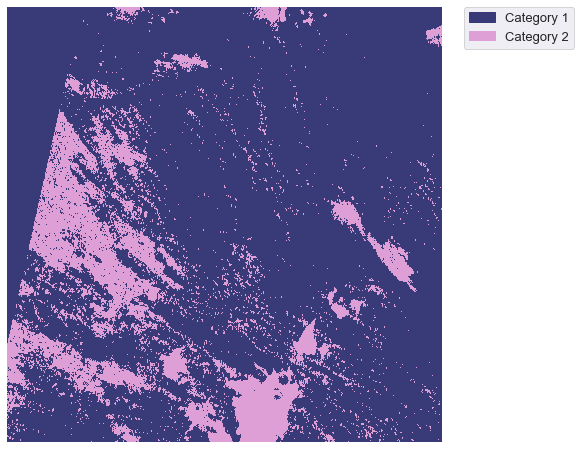

In [260]:
# This is optional code to plot the qa layer - don't worry too much about the details.
# Create a colormap with 101 colors
cmap = plt.cm.get_cmap('tab20b', 2)
# Get a list of unique values in the qa layer
vals = np.unique(landsat_qa_filtered).tolist()
bins = [0] + vals
# Normalize the colormap 
bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
    [(bins[-1] - bins[-2]) + bins[-1]]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(landsat_qa_filtered,
               cmap=cmap,
               norm=norm)

ep.draw_legend(im,
               classes=vals,
               cmap=cmap)

ax.set_axis_off()
plt.show()

In [261]:
landsat_pre_cl_free = em.mask_pixels(
    landsat_pre, landsat_qa_filtered)

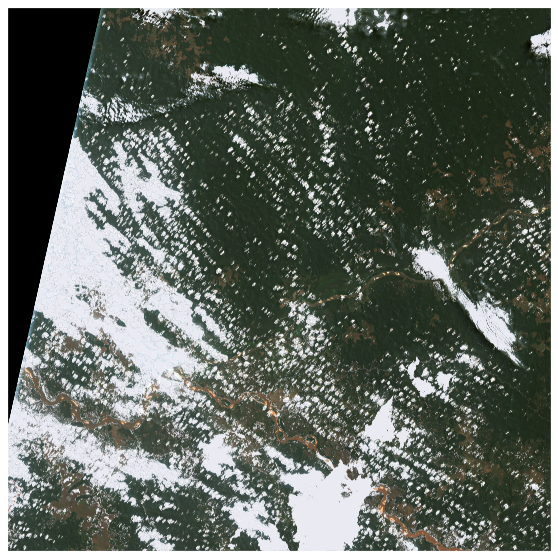

In [262]:
ep.plot_rgb(landsat_pre_cl_free,extent=landsat_ext)

plt.show()

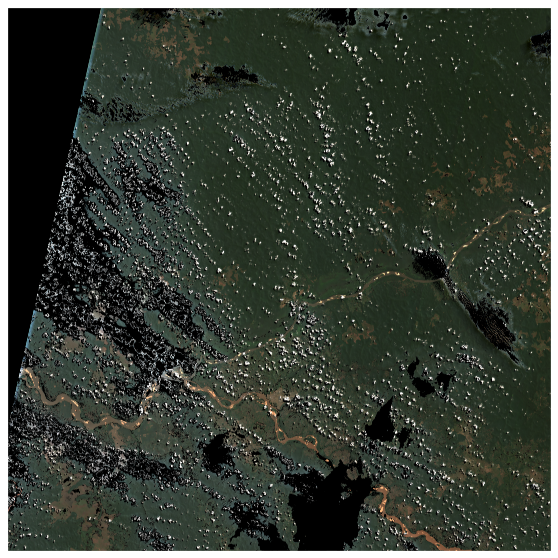

In [263]:
nodatavalue = 0 

ep.plot_rgb(np.ma.filled(landsat_pre_cl_free, fill_value=nodatavalue),extent=landsat_ext)

plt.show()

# Comparing SLC File Cloud mask vs Safe Cloud Mask

In [264]:
sen_raster = '/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Test/Safe_True/L2A_T34MDA_A018108_20200824T085050/IMG_DATA/R10m/T34MDA_20200824T083609_TCI_10m.jp2'
sen_mask = '/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Test/Safe_True/L2A_T34MDA_A018108_20200824T085050/QI_DATA/MSK_CLDPRB_20m.jp2'

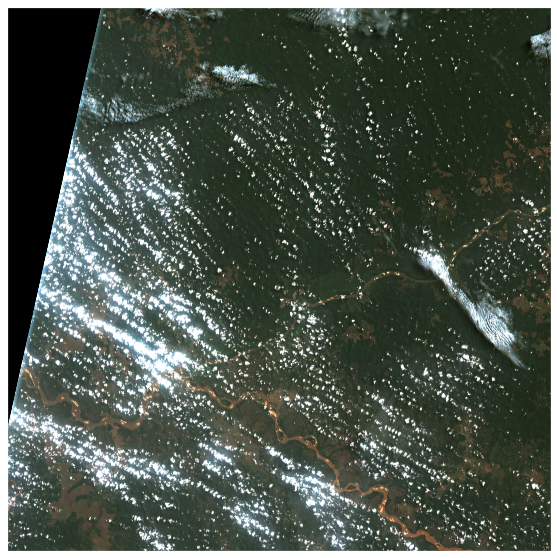

In [265]:
# Read landsat pre fire data
with rio.open(sen_raster) as landsat_pre_src:
    landsat_pre = landsat_pre_src.read(masked=True)
    
ep.plot_rgb(landsat_pre)

plt.show()

In [266]:
landsat_pre_src.meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32734),
 'transform': Affine(10.0, 0.0, 399960.0,
        0.0, -10.0, 9600040.0)}

In [270]:
# Open the pixel_qa layer for your landsat scene
with rio.open(sen_mask) as landsat_pre_cl:
    landsat_qa = landsat_pre_cl.read(1)
    landsat_qa = np.repeat(np.repeat(landsat_qa,2,axis=0),2,axis=1)
    landsat_ext = plotting_extent(landsat_pre_cl)

In [275]:
landsat_qa_filtered = landsat_qa > 0

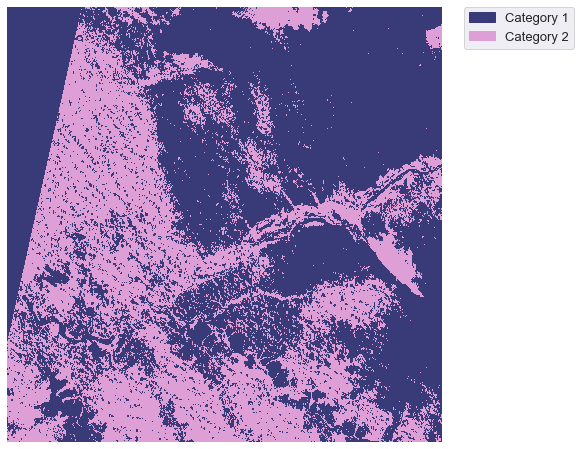

In [276]:
# This is optional code to plot the qa layer - don't worry too much about the details.
# Create a colormap with 101 colors
cmap = plt.cm.get_cmap('tab20b', 2)
# Get a list of unique values in the qa layer
vals = np.unique(landsat_qa_filtered).tolist()
bins = [0] + vals
# Normalize the colormap 
bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
    [(bins[-1] - bins[-2]) + bins[-1]]
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(landsat_qa_filtered,
               cmap=cmap,
               norm=norm)

ep.draw_legend(im,
               classes=vals,
               cmap=cmap)
ax.set_axis_off()
plt.show()

In [278]:
landsat_pre_cl_free = em.mask_pixels(
    landsat_pre, landsat_qa_filtered)

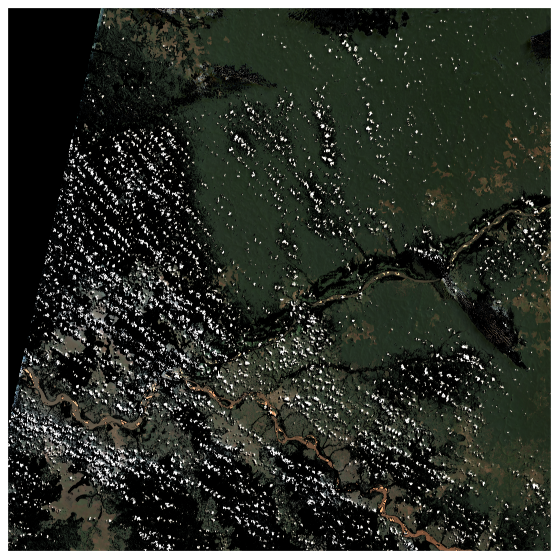

In [279]:
nodatavalue = 0 

ep.plot_rgb(np.ma.filled(landsat_pre_cl_free, fill_value=nodatavalue),extent=landsat_ext)

plt.show()

# End to End Function for filling in Clouds with NODATA

In [184]:
def cloud_fill_nodata(raster_list_base_path):
#     sen_raster_path = glob(raster_base_path + "*/*/*TCI_10m.jp2",recursive=True)[0] 
#     sen_mask_path = glob(raster_base_path + "*/MSK_CLDPRB_20m.jp2",recursive=True)[0]
#     with rio.open(sen_raster) as landsat_pre_src:
#         landsat_pre = landsat_pre_src.read(masked=True)
    
    

In [358]:
src_dir = '/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Test/Raw/'
output_dir = '/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Test/CL_free/'
TCI_list = glob(src_dir + "*/*/*/*TCI_10m.jp2",recursive=True)
Mask_list = glob(src_dir + "*/*/MSK_CLDPRB_20m.jp2",recursive=True)
nodatavalue = int(0) 

for index in range(len(TCI_list)):
    TCI_file = TCI_list[index]
    Mask_file = Mask_list[index]
    TCI_filename = "processed_" + TCI_file.split("/")[-1]
    
    print(f"Processing {TCI_filename}")
    
    with rio.open(TCI_file) as sen_TCI_src:
        sen_TCI = sen_TCI_src.read(masked=True)
        sen_TCI_meta = sen_TCI_src.meta
        
    with rio.open(Mask_file) as sen_mask_src:
        sen_mask_pre = sen_mask_src.read(1)
        sen_mask = np.repeat(np.repeat(sen_mask_pre,2,axis=0),2,axis=1)
        
    sen_mask_qa = sen_mask > 0
    
    #visualize mask, 2 colors
    cmap = plt.cm.get_cmap('tab20b', 2)
    # Get a list of unique values in the qa layer
    vals = np.unique(landsat_qa_filtered).tolist()
    bins = [0] + vals
    # Normalize the colormap 
    bounds = [((a + b) / 2) for a, b in zip(bins[:-1], bins[1::1])] + \
        [(bins[-1] - bins[-2]) + bins[-1]]
    norm = colors.BoundaryNorm(bounds, cmap.N)

#     # Plot the data
#     fig, ax = plt.subplots(figsize=(12, 8))

#     im = ax.imshow(sen_mask_qa,
#                    cmap=cmap,
#                    norm=norm)

#     ep.draw_legend(im,
#                    classes=vals,
#                    cmap=cmap)
#     ax.set_title(f"Mask for {TCI_filename}")
#     ax.set_axis_off()
#     plt.show()
    
    sen_TCI_cl_free_nan = em.mask_pixels(sen_TCI, sen_mask_qa)
    
    sen_TCI_cl_free_processed = np.ma.filled(sen_TCI_cl_free_nan, fill_value=nodatavalue)
    
#     ep.plot_rgb(sen_TCI_cl_free_processed)
#     ax.set_title(f"Plot for {TCI_filename}")
#     plt.show()
    

    with rio.open(output_dir + TCI_filename, 'w', **sen_TCI_meta) as outf:
        outf.write(sen_TCI_cl_free_processed)
    
    

Processing processed_T33NUC_20190401T090559_TCI_10m.jp2
Processing processed_T33NUC_20190404T092029_TCI_10m.jp2
Processing processed_T33NUC_20191217T091309_TCI_10m.jp2
Processing processed_T33NUC_20191217T091309_TCI_10m.jp2
Processing processed_T33NUC_20191230T092309_TCI_10m.jp2
Processing processed_T33NUC_20200806T092029_TCI_10m.jp2
Processing processed_T33NUC_20200111T091341_TCI_10m.jp2
Processing processed_T33NUC_20200114T092331_TCI_10m.jp2
Processing processed_T33NUC_20200124T092251_TCI_10m.jp2
Processing processed_T33NWA_20190210T091119_TCI_10m.jp2


# Sandbox 

In [341]:
raster_path = "/Volumes/Lacie/zhenyadata/Project_Canopy_Data/PC_Data/Sentinel_Data/Labelled/Test/CL_free/processed_T33NWA_20200210T091121_TCI_10m.jp2"

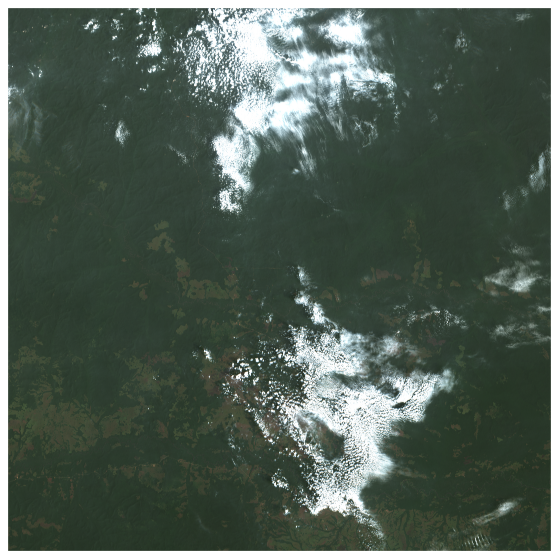

In [343]:
# Read landsat pre fire data
with rio.open(raster_path) as test_pre_src:
    test_pre = test_pre_src.read(masked=True)
    
ep.plot_rgb(landsat_pre)

plt.show()

In [344]:
test_pre

masked_array(
  data=[[[52, 50, 49, ..., 50, 49, 54],
         [49, 50, 49, ..., 50, 51, 54],
         [50, 51, 50, ..., 53, 52, 53],
         ...,
         [67, 64, 62, ..., 47, 48, 49],
         [72, 73, 65, ..., 49, 49, 49],
         [74, 73, 66, ..., 50, 49, 48]],

        [[65, 63, 62, ..., 63, 62, 66],
         [62, 63, 63, ..., 64, 64, 66],
         [62, 64, 63, ..., 68, 66, 66],
         ...,
         [69, 66, 62, ..., 61, 63, 62],
         [67, 65, 64, ..., 63, 64, 64],
         [69, 65, 66, ..., 63, 64, 64]],

        [[53, 53, 54, ..., 53, 54, 59],
         [55, 56, 55, ..., 55, 53, 56],
         [56, 58, 56, ..., 54, 53, 54],
         ...,
         [49, 51, 48, ..., 45, 46, 45],
         [50, 49, 47, ..., 46, 44, 47],
         [51, 47, 46, ..., 44, 44, 48]]],
  mask=[[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False,

In [345]:
test_pre_src.meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(10.0, 0.0, 499980.0,
        0.0, -10.0, 100020.0)}